In [ ]:
! pip install wandb

In [ ]:
! pip install --upgrade scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split
import wandb
from keras.datasets import fashion_mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

### DOWNLOADING THE DATASET AND PLOTTING ONE SAMPLE IMAGE FROM EACH CLASS

In [ ]:
def plot_images():
  wandb.login(key = "aecb4b665a37b40204530b0627a42274aeddd3e1")
  # start a new wandb run to track this script
  wandb.init(project="CS6910_Assignment-1",entity="cs22m078")
  # simulate training
  # x_train is a (60000,28,28) matrix consisting image pixels for training
  # y_train is a (60000,1) matrix consisting of labels
  # x_test is a (10000,28,28) matrix consisting image pixels for testing
  # y_test is a (10000,1) matrix consisting of labels for testing
  (x_train, y_train), (x_test, y_test) =fashion_mnist.load_data()
  labels=set()
  i=0
  fig,ax=plt.subplots(2,5,figsize=(10,5))
  row=0
  col=0
  for pixels in x_train:
    #The matplotlib function imshow() creates an image from a 2-dimensional numpy array
    #pixels is (28,28) 2-D array
    #l is the current label of image
    l=y_train[i]
    if(not(l in labels)):
      if(col>=5):
        col=0
        row+=1
      ax[row][col].imshow(pixels,cmap="gray")
      ax[row][col].set_title("Label {}".format(l))
      ax[row][col].axis(False)
      labels.add(l)
      col+=1
    #if we get all our 10 labels just break the loop
    if(len(labels)==10):
      break;
    i+=1
  wandb.log({"plot":plt})
  wandb.run.name = "Sample_Images"
  wandb.run.save()
  wandb.run.finish()
  # finish the wandb run, necessary in notebooks
  wandb.finish()

## DATA-PREPROCESSING

In [ ]:
def data_preprocess():
    (x_train, y_train), (x_test, y_test) =fashion_mnist.load_data()
    #NORMALIZING THE DATASET
    x_train=x_train/255.0
    x_test=x_test/255.0
    #RESHAPING THE TRAIN_IMAGE DATASET FROM (60000,28x28) TO (60000,784) AND SAME FOR TEST_IMAGE
    num_inputs=784
    num_outputs=10
    x_train=x_train.reshape(60000,784)
    x_test=x_test.reshape(10000,784)


    #SPLITTING THE TRAINING DATA FOR VALIDATION AND TESTING
    train_x,val_x,train_y,val_y=train_test_split(x_train,y_train)
    train_x=np.transpose(train_x)
    train_y=np.transpose(train_y)
    val_x=np.transpose(val_x)
    val_y=np.transpose(val_y)
    #RESHAPING MY DATA TO COLUMN-WISE IMAGES
    x_train=x_train.T
    x_test=x_test.T
    return x_train,y_train,train_x,train_y,val_x,val_y,x_test, y_test

#ONE-HOT ENCODING FOR Y_TRAIN AND Y_TEST: 
def one_hot_encoding(y):
    exp_y=np.zeros((10,y.shape[0]))
    for i in range(0,y.shape[0]):
        exp_y[y[i]][i]=1
    return exp_y



### ACTIVATION FUNCTIONS

In [ ]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return np.multiply(s, np.subtract(1, s))

def softmax(x):
    x=x-np.max(x)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def Relu(x):
    return np.maximum(0,x)

def identity(x):
    return x

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

### INITIALIZING THE PARAMETERS

In [ ]:
def initialize_params(hidden_layers,neurons,method):
  #USING XAVIER INITIALIZATION TO INITIALIZE WEIGHTS AND BIAS MATRIX

  #INDEXING DONE FROM 1
  L=hidden_layers+1 #number of layers excluding hidden layer
  weights=[0]*(hidden_layers+2)
  biases=[0]*(hidden_layers+2)
  previous_updates_W=[0]*(hidden_layers+2)
  previous_updates_B=[0]*(hidden_layers+2)
  np.random.seed(42)
  for i in range(1,hidden_layers+1):
    n=neurons[i]
    # appending the weight and bias matrix for the ith layer
    if(i==1):
      if method=='xavier':
        weights[i]=(np.random.randn(n,784)*np.sqrt(2/(n+784)))
      if method=='random':
        weights[i]=(np.random.randn(n,784))*0.01
      biases[i]=(np.zeros((n,1)))
      previous_updates_W[i]=np.zeros((n,784))
      previous_updates_B[i]=np.zeros((n,1))
      # biases[i]=(np.random.randn(n,1))
    else:
      if method=='xavier':
        weights[i]=(np.random.randn(n,neurons[i-1])*np.sqrt(2/(n+neurons[i-1])))
      if method=='random':
        weights[i]=(np.random.randn(n,neurons[i-1]))*0.01
      biases[i]=(np.zeros((n,1)))
      previous_updates_W[i]=np.zeros((n,neurons[i-1]))
      previous_updates_B[i]=np.zeros((n,1))
      # biases[i]=(np.random.randn(n,1))
  weights[L]=(np.random.randn(10,neurons[hidden_layers])*np.sqrt(2/(10+neurons[hidden_layers-1])))
  biases[L]=(np.zeros((10,1)))
  previous_updates_W[L]=np.zeros((10,neurons[hidden_layers]))
  previous_updates_B[L]=np.zeros((10,1))
  weights=np.array(weights,dtype=object)
  biases=np.array(biases,dtype=object)
  previous_updates_W=np.array(previous_updates_W,dtype=object)
  previous_updates_B=np.array(previous_updates_B,dtype=object)
  return weights,biases,previous_updates_W,previous_updates_B

## FEED FORWARD PROPOGATION

In [ ]:
def FeedForwardNetwork(weights,biases,L,data,activation):
  #Returns the array containing the output probablity for each class the data can belong
  a=[0]*(L+1)
  h=[0]*(L+1)
  h[0]=data
  for i in range(1,L):
    #weight and bias matrix for hidden-layer i
    weight=weights[i]
    bias=biases[i]
    #pre activation
    a[i]=(bias+np.matmul(weight,h[i-1]))
    #post activation
    if(activation=='sigmoid'):
      h[i]=(sigmoid(a[i]))
    if(activation=='relu'):
      h[i]=(Relu(a[i]))
    if(activation=='tanh'):
      h[i]=(tanh(a[i]))
    if(activation=='identity'):
      h[i]=(identity(a[i]))
  #weight and bias matrix for ouput layer
  weight=weights[L]
  bias=biases[L]
  a[L]=(bias+np.matmul(weight,h[L-1]))
  h[L]=softmax(a[L])
  return h[L],h,a

## BACK PROPOGATION

In [ ]:
def BackPropogation(weights,L,H,A,exp_Y,y_hat,activation,loss="cross_entropy"):
  # Input Parameters of function
  # --> Model Parameters: weights and biases
  # --> H: Post-activations, A: Pre-Activations
  # --> exp_Y: Actual Class Labels
  # Returns list of gradients for each layer wrt weights and biases(parameters)
  gradients_H=[0] * (L+1)
  gradients_W=[0] * (L+1)
  gradients_B=[0] * (L+1)
  gradients_A=[0] * (L+1)
  
  #Computing Gradient For The Output Layer(Pre Activation)
  if loss=="cross_entropy":
    gradients_A[L]=-(exp_Y-y_hat)
  if loss=="mse":
    gradients_A[L]=(2 / y_hat.shape[1]) * (y_hat-exp_Y)
  for k in range(L,0,-1):
    #compute gradients of the parameters
    gradients_W[k]=np.matmul(gradients_A[k],np.transpose(H[k-1]))
    gradients_B[k]=np.sum(gradients_A[k], axis=1,keepdims=True)
    #compute gradients of the hidden layers
    gradients_H[k-1]=np.matmul(np.transpose(weights[k]),gradients_A[k])
    if(k>1):
      if activation=='sigmoid':
        gradients_A[k-1]=np.multiply(gradients_H[k-1],sigmoid_derivative(A[k-1]))
      if activation=='relu':
        gradients_A[k-1]=np.multiply(gradients_H[k-1],Relu_derivative(A[k-1]))
      if activation=='tanh':
        gradients_A[k-1]=np.multiply(gradients_H[k-1],tanh_derivative(A[k-1]))
      if activation=='identity':
        gradients_A[k-1]=gradients_H[k-1]


  return gradients_W,gradients_B

## LOSS AND ACCURACY FUNCTIONS

In [ ]:
def calc_loss(weights,y,exp_y,loss,data_size,L2_lamb):
    # Calculating -log(p(x)) where p(x) is probablity where our of our actual class label of x
    # exp_y contains y=1 if y is actual class of x else 0
    # so dot product gives only the log of the probablity of actual class of x
    loss_val=0
    if loss=='cross_entropy':
        p_x= np.multiply(exp_y,np.log(y))
        loss_val= -np.sum(p_x)/data_size
    if loss=='MSE':
        p_x=(y-exp_y)**2
        loss_val= 0.5 * np.sum(p_x)/data_size
    # Applying L2_regulaization
    square_sum=0
    for i in range(1,len(weights)):
        square_sum+=np.sum(np.square(weights[i]))
    loss_val=loss_val+(L2_lamb/(2*data_size))*square_sum
    return loss_val
    

def calc_accuracy(y,predicted_y):
    correct=0
    for i in range(len(y)):
        if(y[i]==predicted_y[i]):
            correct+=1
    return (correct/len(y))*100

## FUNCTIONS FOR UPDATION OF PARAMETERS

In [ ]:
def sgd_params_update(weights,biases,gradients_W,gradients_B,eta,L,L2_lamb):
    gradients_B=np.array(gradients_B,dtype=object)
    gradients_W=np.array(gradients_W,dtype=object)
    for i in range(1,L+1):
      weights[i]=weights[i]-eta*gradients_W[i] -(eta * L2_lamb * weights[i])
      biases[i]=biases[i]-eta*gradients_B[i]
    return weights,biases


def update_parameters_momentum(weights, biases, gradients_B,gradients_W, beta, previous_updates_W,previous_updates_B,eta,L,L2_lamb):
    gradients_B=np.array(gradients_B,dtype=object)
    gradients_W=np.array(gradients_W,dtype=object)
    for i in range(1,L+1):
      previous_updates_W[i]=beta*previous_updates_W[i]+(1-beta)*gradients_W[i]
      previous_updates_B[i]=beta*previous_updates_B[i]+(1-beta)*gradients_B[i]
      weights[i]=weights[i]-eta*previous_updates_W[i]-(eta * L2_lamb * weights[i])
      biases[i]=biases[i]-eta*previous_updates_B[i]
    return weights,biases,previous_updates_W,previous_updates_B


def update_parameters_adam(weights, biases, gradients_B,gradients_W,eta, m_W,m_B,v_W,v_B,t,L,L2_lamb,beta1,beta2,epsilon):
    gradients_B=np.array(gradients_B,dtype=object)
    gradients_W=np.array(gradients_W,dtype=object)
    for i in range(1,L+1):
      m_dw=beta1*m_W[i]+(1-beta1)*gradients_W[i]
      v_dw=beta2*v_W[i]+(1-beta2)*np.square(gradients_W[i])
      m_W_hat=m_dw/(1.0 -beta1**t)
      v_W_hat=v_dw/(1.0 -beta2**t)
      v_W[i]=v_dw
      m_W[i]=m_dw
      m_db=beta1*m_B[i]+(1-beta1)*gradients_B[i]
      v_db=beta2*v_B[i]+(1-beta2)*np.square(gradients_B[i])
      m_B_hat=m_db/(1.0 -beta1**t)
      v_B_hat=v_db/(1.0 -beta2**t)
      weights[i]=weights[i]-(eta*m_W_hat)/np.sqrt(v_W_hat+epsilon)-(eta * L2_lamb * weights[i])
      biases[i]=biases[i]-(eta*m_B_hat)/np.sqrt(v_B_hat+epsilon)
      v_B[i]=v_db
      m_B[i]=m_db
    t=t+1
    return weights,biases,m_W,m_B,v_W,v_B,t


def rmsprop_params_update(weights, biases, gradients_B,gradients_W, beta,eta, W_v,B_v,L,L2_lamb):
    gradients_B=np.array(gradients_B,dtype=object)
    gradients_W=np.array(gradients_W,dtype=object)
    for i in range(1,L+1):
      v_dw= beta*W_v[i]+np.multiply(gradients_W[i],gradients_W[i])
      v_db= beta*B_v[i]+np.multiply(gradients_B[i],gradients_B[i])
      weights[i]=weights[i]-(eta*(gradients_W[i]))/np.sqrt((v_dw)+1e-4)-(eta * L2_lamb * weights[i])
      biases[i]=biases[i]-(eta*(gradients_B[i]))/np.sqrt((v_db)+1e-4)
      W_v[i]=v_dw
      B_v[i]=v_db
    return weights,biases,W_v,B_v


### LEARNING PARAMETERS

In [ ]:
def learning_params(hidden_layers,neuron,x_train,y_train,x_val,y_val,learning_algorithm,eta,epochs,batch_size,activation,init_method,L2_lamb,momemtum=0.9 ,beta=0.9 ,beta1=0.9 ,beta2=0.99 ,epsilon=0.00001,loss="cross_entropy"):
  count=1
  predicted_y=[]
  L=hidden_layers+1
  neurons=[0]*(L)
  for i in range(1,L):
    neurons[i]=neuron
  exp_y=one_hot_encoding(y_train)
  exp_y_val=one_hot_encoding(y_val)
  i
  weights,biases,previous_updates_W,previous_updates_B=initialize_params(hidden_layers,neurons,init_method)
  epoch_train_loss=[]
  epoch_val_loss=[]
  acc_val=[]
  acc_train=[]
  t=1
  v_W = previous_updates_W.copy()
  m_W = previous_updates_W.copy()
  v_B = previous_updates_B.copy()
  m_B = previous_updates_B.copy()
  while count<=epochs:
      for i in range(0,x_train.shape[1],batch_size):
        mini_batch=x_train[:,i:i+batch_size]
        if learning_algorithm=='nag':
          W_look_ahead=weights-(beta)*previous_updates_W
          B_look_ahead=biases-(beta)*previous_updates_B
          output,post_act,pre_act=FeedForwardNetwork(W_look_ahead,B_look_ahead,L,mini_batch,activation)
          gradients_W,gradients_B=BackPropogation(W_look_ahead,L,post_act,pre_act,exp_y[:,i:i+batch_size],output,activation,loss)
          weights,biases,previous_updates_W,previous_updates_B=update_parameters_momentum(weights,biases, gradients_B,gradients_W, beta, previous_updates_W,previous_updates_B,eta,L,L2_lamb)
        elif learning_algorithm=='nadam':
          W_look_ahead=weights-(beta)*previous_updates_W
          B_look_ahead=biases-(beta)*previous_updates_B
          output,post_act,pre_act=FeedForwardNetwork(W_look_ahead,B_look_ahead,L,mini_batch,activation)
          gradients_W,gradients_B=BackPropogation(W_look_ahead,L,post_act,pre_act,exp_y[:,i:i+batch_size],output,activation,loss)
          weights,biases,m_W,m_B,v_W,v_B,t= update_parameters_adam(weights, biases, gradients_B,gradients_W,eta, m_W,m_B,v_W,v_B, t,L,L2_lamb,beta1,beta2,epsilon)
        elif learning_algorithm=='momemtum':
            output,post_act,pre_act=FeedForwardNetwork(weights,biases,L,mini_batch,activation)
            gradients_W,gradients_B=BackPropogation(weights,L,post_act,pre_act,exp_y[:,i:i+batch_size],output,activation,loss)
            weights,biases,previous_updates_W,previous_updates_B=update_parameters_momentum(weights, biases, gradients_B,gradients_W, momemtum, previous_updates_W,previous_updates_B,eta,L,L2_lamb)
        elif learning_algorithm=='sgd':
            output,post_act,pre_act=FeedForwardNetwork(weights,biases,L,mini_batch,activation)
            gradients_W,gradients_B=BackPropogation(weights,L,post_act,pre_act,exp_y[:,i:i+batch_size],output,activation,loss)
            weights,biases=sgd_params_update(weights,biases,gradients_W,gradients_B,eta,L,L2_lamb)
        elif learning_algorithm=='adam':
            output,post_act,pre_act=FeedForwardNetwork(weights,biases,L,mini_batch,activation)
            gradients_W,gradients_B=BackPropogation(weights,L,post_act,pre_act,exp_y[:,i:i+batch_size],output,activation,loss)
            weights,biases,m_W,m_B,v_W,v_B,t= update_parameters_adam(weights, biases, gradients_B,gradients_W,eta, m_W,m_B,v_W,v_B, t,L,L2_lamb,beta1,beta2,epsilon)
        elif learning_algorithm=='rmsprop':
            output,post_act,pre_act=FeedForwardNetwork(weights,biases,L,mini_batch,activation)
            gradients_W,gradients_B=BackPropogation(weights,L,post_act,pre_act,exp_y[:,i:i+batch_size],output,activation,loss)
            weights,biases,previous_updates_W,previous_updates_B = rmsprop_params_update(weights, biases, gradients_B,gradients_W, beta,eta, previous_updates_W,previous_updates_B,L,L2_lamb)
        else:
            break;
      full_output_train,_,_=FeedForwardNetwork(weights,biases,L,x_train,activation)
      full_output_val,_,_=FeedForwardNetwork(weights,biases,L,x_val,activation)
      loss_train=calc_loss(weights,full_output_train,exp_y,'cross_entropy',full_output_train.shape[1],L2_lamb)
      loss_val=calc_loss(weights,full_output_val,exp_y_val,'cross_entropy',full_output_val.shape[1],L2_lamb)
      acc_train.append(calc_accuracy(y_train,np.argmax(full_output_train,axis=0)))
      acc_val.append(calc_accuracy(y_val,np.argmax(full_output_val,axis=0)))
      epoch_train_loss.append(loss_train)
      epoch_val_loss.append(loss_val)
      count+=1
  return weights,biases,epoch_train_loss,epoch_val_loss,acc_train,acc_val

In [ ]:
def run_sweeps(train_x,train_y,val_x,val_y):

    config = {
        "project":"CS6910_Assignment-1",
        "method": 'random',
        "metric": {
        'name': 'acc',
        'goal': 'maximize'
        },
        'parameters' :{
        "hidden_layers": {"values":[3,4,5,6]},
        "neurons": {"values": [32,64,128]},
        "learning_algorithm": {"values":["momemtum","sgd","nag","rmsprop","nadam","adam"]},
        "eta": {"values":[1e-3,1e-4]},
        "epoch": {"values":[5,10]},
        "batch_size": {"values":[16,32,64]},
        "activation": {"values":["tanh","relu","sigmoid"]},
        "weight_init":{"values":["random","xavier"]},
        "L2_lamb":{"values":[0,0.0005,0.5]}
        }
    }

    def trainn():
        wandb.init()
        name='_h1_'+str(wandb.config.hidden_layers)+"_SL_"+str(wandb.config.neurons)+"_BS_"+str(wandb.config.batch_size)+"_OPT_"+str(wandb.config.learning_algorithm)
        _,_,epoch_train_loss,epoch_val_loss,acc_train,acc_val=learning_params(wandb.config.hidden_layers,wandb.config.neurons,train_x,train_y,val_x,val_y,wandb.config.learning_algorithm,wandb.config.eta,wandb.config.epoch,wandb.config.batch_size,wandb.config.activation,wandb.config.weight_init,wandb.config.L2_lamb)
        for i in range(len(epoch_train_loss)):
            wandb.log({"loss":epoch_train_loss[i]})
            wandb.log({"val_loss":epoch_val_loss[i]})
            wandb.log({"accuracy":acc_train[i]})
            wandb.log({"val_acc":acc_val[i]})
            wandb.log({"epoch": (i+1)})
        wandb.log({"acc":acc_val[-1]})
        wandb.run.name = name
        wandb.run.save()
        wandb.run.finish()
    sweep_id=wandb.sweep(config,project="CS6910_Assignment-1")
    wandb.agent(sweep_id,function=trainn,count=200)

## Confusion Matrix

In [86]:
def log_confusion_mat():    
    wandb.init(project="CS6910_Assignment-1",entity="cs22m078")
    _,_,train_x,train_y,val_x,val_y,x_test,y_test=data_preprocess()
    hidden_layers=6
    weights,biases,epoch_train_loss,epoch_val_loss,acc_train,acc_val=learning_params(hidden_layers=6,neuron=64,x_train=train_x,y_train=train_y,x_val=val_x,y_val=val_y,learning_algorithm="nadam",eta=0.001,epochs=10,batch_size=32,activation="relu",init_method="xavier",L2_lamb=0.0005,momemtum=0.9 ,beta=0.9 ,beta1=0.9 ,beta2=0.99 ,epsilon=0.00001)
    L=hidden_layers+1
    full_output_test,_,_=FeedForwardNetwork(weights,biases,L,x_test,"relu")
    predicted_y=np.argmax(full_output_test,axis=0)
    predicted_y=np.array(predicted_y,dtype=object)
    pred_y=predicted_y
    p_y=pred_y.tolist()
    y_t=y_test.tolist()
    conf= metrics.confusion_matrix(p_y,y_t)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf,display_labels=np.array(["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Boot"]))
    fig, ax = plt.subplots(figsize=(11,11))
    cm_display.plot(ax=ax)
    wandb.log({"confusion_matrix":plt})
    wandb.run.name = "Confusion Matrix"
    wandb.run.save()
    wandb.run.finish()

## Plotting MSE and Cross-Entropy Curve

In [ ]:
def plot_cost_curve(epoch_train_loss_mse, epoch_train_loss):
    wandb.init(project="CS6910_Assignment-1",entity="cs22m078")
    plt.plot(list(range(len(epoch_train_loss_mse))), epoch_train_loss_mse, 'r', label="Training loss MSE")
    plt.plot(list(range(len(epoch_train_loss))), epoch_train_loss, 'lime', label="Training loss Cross Entropy")
    plt.title("MSE Vs Cross-Entropy Plot", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.legend()
    wandb.log({"MSE Vs Cross-Entropy Plot":wandb.Image(plt)})
    wandb.run.name = "MSE Vs Cross-Entropy Plot"
    wandb.run.save()
    wandb.run.finish()

In [ ]:
def bestfit(train_x,train_y,val_x,val_y):
    _,_,epoch_train_loss_cross,_,_,_=learning_params(hidden_layers=6,neuron=64,x_train=train_x,y_train=train_y,x_val=val_x,y_val=val_y,learning_algorithm="nadam",eta=0.001,epochs=10,batch_size=32,activation="relu",init_method="xavier",L2_lamb=0.0005,momemtum=0.9 ,beta=0.9 ,beta1=0.9 ,beta2=0.99 ,epsilon=0.00001)
    _,_,epoch_train_loss_mse,_,_,_=learning_params(hidden_layers=6,neuron=64,x_train=train_x,y_train=train_y,x_val=val_x,y_val=val_y,learning_algorithm="nadam",eta=0.001,epochs=10,batch_size=32,activation="relu",init_method="xavier",L2_lamb=0.0005,momemtum=0.9 ,beta=0.9 ,beta1=0.9 ,beta2=0.99 ,epsilon=0.00001,loss="mse")
    return epoch_train_loss_cross,epoch_train_loss_mse

In [ ]:
_,_,train_x,train_y,val_x,val_y,_,_=data_preprocess()
epoch_train_loss_cross, epoch_train_loss_mse=bestfit(train_x,train_y,val_x,val_y)
plot_cost_curve(epoch_train_loss_mse, epoch_train_loss_cross)

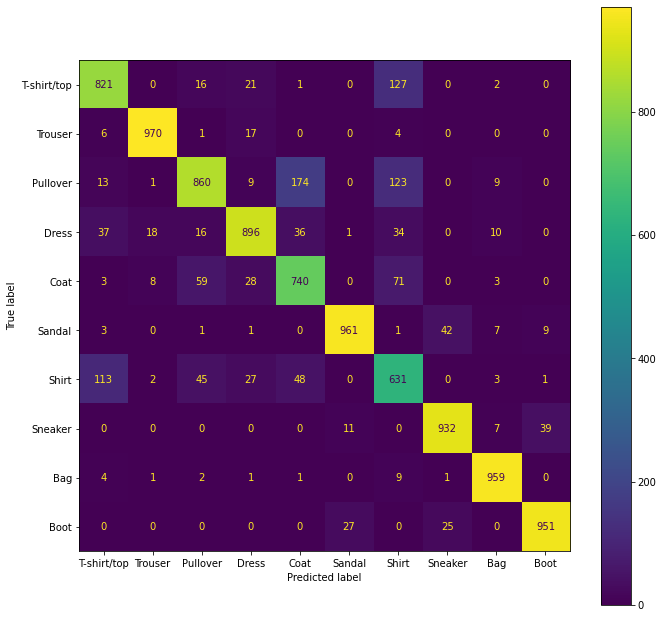

In [87]:
log_confusion_mat()

In [ ]:
def main():
    plot_images()
    _,_,train_x,train_y,val_x,val_y,_,_=data_preprocess()
    run_sweeps(train_x,train_y,val_x,val_y)
    log_confusion_mat()
    epoch_train_loss_cross, epoch_train_loss_mse=bestfit(train_x,train_y,val_x,val_y)
    plot_cost_curve(epoch_train_loss_mse, epoch_train_loss_cross)

if __name__=="__main__":
    main()